# IDH Mutation Status Classification

## Import

In [1]:
import pandas as pd
from openslide import OpenSlide
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import copy
from matplotlib.ticker import MaxNLocator

## Main paths  

In [2]:
dataset_folder = "C:/Users/solam/Desktop/CPath/Dataset"
trident_folder="C:/Users/solam/Desktop/CPath/TRIDENT"
train_data_property_path= os.path.join(dataset_folder, "train.csv")

## WSI Segmentation

All analysis was performed using Triddent.

## Patch Extraction

### 4.1 Check the WSI size:

In [43]:
train_wsi_folder= os.path.join(dataset_folder, "train")
mpp_x_list = []
mpp_y_list = []
for filename in os.listdir(train_wsi_folder):
    slide_path = os.path.join(train_wsi_folder, filename)
    slide = OpenSlide(slide_path)
          
    mpp_x = float(slide.properties.get("openslide.mpp-x", "0"))
    mpp_y = float(slide.properties.get("openslide.mpp-y", "0"))
    mpp_x_list.append(mpp_x)
    mpp_y_list.append(mpp_y)
    
# Calculate MPP statistics
min_mpp_x = min(mpp_x_list)
max_mpp_x = max(mpp_x_list)
avg_mpp_x = sum(mpp_x_list) / len(mpp_x_list)
min_mpp_y = min(mpp_y_list)
max_mpp_y = max(mpp_y_list)
avg_mpp_y = sum(mpp_y_list) / len(mpp_y_list)
# print MPP statistics
print(f"MPP X: min={min_mpp_x}, max={max_mpp_x}, avg={avg_mpp_x}")
print(f"MPP Y: min={min_mpp_y}, max={max_mpp_y}, avg={avg_mpp_y}")

MPP X: min=0.2456, max=0.5015, avg=0.2787320000000005
MPP Y: min=0.2456, max=0.5015, avg=0.2787320000000005


### 4.3 Analysis the number of patchs

In [44]:
# Count the number of patch per WSI:
train_patches_folder= os.path.join(trident_folder, "trident_processed_hest_train/20x_256px_0px_overlap/patches")

patch_counts_list = []
# Read all h5 files and count the number of patch per WSI:
for filename in os.listdir(train_patches_folder): # loop per WSI
    if filename.lower().endswith(".h5"):
        h5_path = os.path.join(train_patches_folder, filename)
        with h5py.File(h5_path, "r") as f:
            num_patches = f["coords"].shape[0]
            patch_counts_list.append({"filename": filename, "num_patches": num_patches})

patch_counts = pd.DataFrame(patch_counts_list)

train_data_label = pd.read_csv(train_data_property_path, usecols=["filename", "mIDH"]) # read the labels from the csv file

# Join the patch count with the mutation IDH label
patch_counts["filename"] = patch_counts["filename"].str.replace(r"_patches\.h5$", "", regex=True) 
train_data_label["filename"] = train_data_label["filename"].str.replace(r".svs$", "", regex=True)
merged_df = pd.merge(train_data_label, patch_counts, on="filename", how="left")
merged_df["mIDH_label"] = merged_df["mIDH"].map({False: "IDH-", True: "IDH+"})

# Analysis:
mean_patches = merged_df["num_patches"].mean()
min_patches = merged_df["num_patches"].min()
max_patches = merged_df["num_patches"].max()
print(f"Average patches per WSI: {mean_patches:.0f}")
print(f"Range of patches per WSI: {min_patches} – {max_patches}")
# Analysis by DHI
dhi_stats = merged_df.groupby("mIDH")["num_patches"].agg(["mean", "min", "max"])
print("\nPatches per WSI by IDH:")
for dhi, row in dhi_stats.iterrows():
    print(f"DHI {dhi}: mean={row['mean']:.0f}, range={int(row['min'])}–{int(row['max'])}")


Average patches per WSI: 10432
Range of patches per WSI: 315 – 31262

Patches per WSI by IDH:
DHI False: mean=8431, range=386–24663
DHI True: mean=12354, range=315–31262


### 5. Plot per case mIDH:

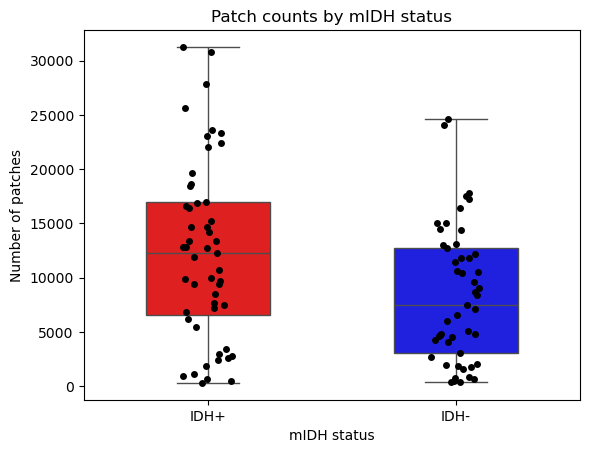

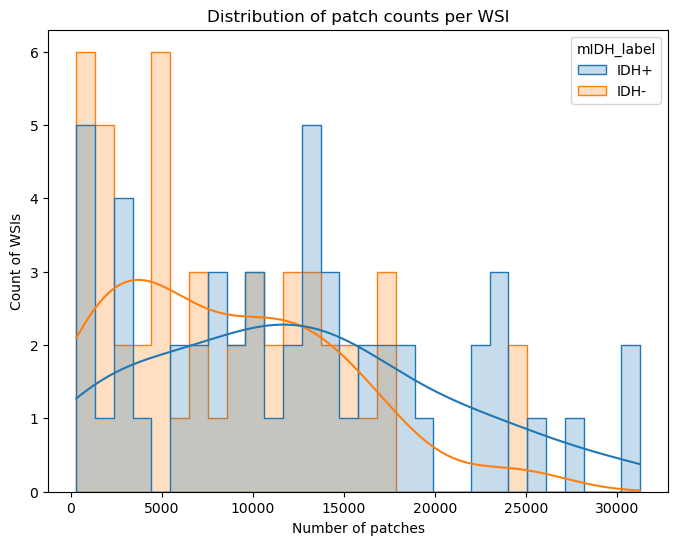

In [45]:
# Boxplot:
sns.boxplot(
    data=merged_df,
    x="mIDH_label", 
    y="num_patches",
    hue="mIDH_label",        # add hue
    palette={"IDH+": "red", "IDH-": "blue"},
    showfliers=False,
    width=0.5,
    dodge=False               # keep boxes together since hue matches x
)

sns.stripplot(
    data=merged_df,
    x="mIDH_label", 
    y="num_patches",
    color="black",
    jitter=True
)
plt.xlabel("mIDH status")
plt.ylabel("Number of patches")
plt.title("Patch counts by mIDH status")
plt.show()

# Histogram
plt.figure(figsize=(8,6))
sns.histplot(data=merged_df, x="num_patches", hue="mIDH_label", bins=30, kde=True, element="step")
plt.xlabel("Number of patches")
plt.ylabel("Count of WSIs")
plt.title("Distribution of patch counts per WSI")
plt.show()

## Embeddings extraction

### 7. t-SNE plot 

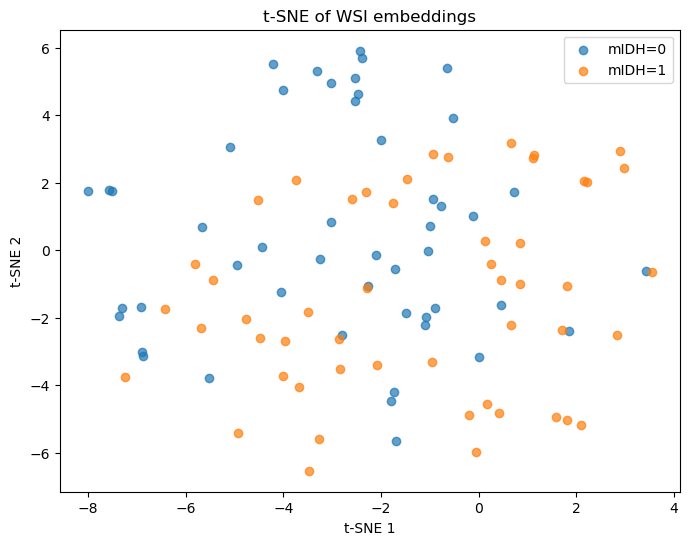

In [46]:
# read data 
train_embedding_folder= os.path.join(trident_folder, "trident_processed_hest_train/20x_256px_0px_overlap/features_uni_v2")
train_data_label = pd.read_csv(train_data_property_path, usecols=["filename", "mIDH"])
train_data_label["filename"] = train_data_label["filename"].str.replace(r".svs$", "", regex=True)

slides_features=[]
slides_labels=[]

for fname in os.listdir(train_embedding_folder):    
    fpath = os.path.join(train_embedding_folder, fname)
    
    # find matching row in DataFrame (for labeling)
    base_name = os.path.splitext(fname)[0]
    row = train_data_label.loc[train_data_label["filename"] == base_name]
    if row.empty:
        print(f"No label for {base_name}, skipping")
        continue

    label =  int(row["mIDH"].values[0])

    # read features
    with h5py.File(fpath, "r") as f:
        feats = f["features"][:]  # shape: (N_patches, D)
        
    # aggregate to slide-level by taking mean over patches
    slide_feat = np.mean(feats, axis=0)  # shape: (D,)
    slides_features.append(slide_feat)
    slides_labels.append(label)

# Convert to numpy arrays
slides_features = np.stack(slides_features)  # shape: (N_slides, D)
slides_labels = np.array(slides_labels)

# Run t-SNE
tsne = TSNE(n_components=2)
slides_2d = tsne.fit_transform(slides_features)

# Plot
plt.figure(figsize=(8,6))
for lbl in np.unique(slides_labels):
    idx = slides_labels == lbl
    plt.scatter(slides_2d[idx, 0], slides_2d[idx, 1], label=f"mIDH={lbl}", alpha=0.7)
plt.legend()
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of WSI embeddings")
plt.show()

### SVM on this embeddings

In [48]:
# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(slides_features, slides_labels, test_size=0.2)

# Train SVM
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)

# Predict on validation set
y_pred = svm_clf.predict(X_val)

# Compute metrics on the unseen data
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print(f"Overall Metrics (all {len(y_pred)} slides):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


# Compute metrics on all the train dataset
y_pred = svm_clf.predict(slides_features)

accuracy = accuracy_score(slides_labels, y_pred)
precision = precision_score(slides_labels, y_pred)
recall = recall_score(slides_labels, y_pred)
f1 = f1_score(slides_labels, y_pred)
auc = roc_auc_score(slides_labels, y_pred)

print(f"Overall metrics across all {len(y_pred)} slides (entire training dataset):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Overall Metrics (all 20 slides):
Accuracy: 0.9000
Precision: 1.0000
Recall: 0.7500
F1-score: 0.8571
AUC: 0.8750
Overall metrics across all 100 slides (entire training dataset):
Accuracy: 0.9600
Precision: 0.9608
Recall: 0.9608
F1-score: 0.9608
AUC: 0.9600


## IDH Classification

### Model hyperparameters

In [21]:
# Adjust per embedding type (UNI2 / ResNet50)
embedding_dim = 1536  # for UNI2: 1536 and for Resnet50: 1024  
train_embedding_folder= os.path.join(trident_folder, "trident_processed_hest_train/20x_256px_0px_overlap/features_uni_v2")

# hyperparameters
attention_hidden = 128      # size of hidden layer- attention
classifier_hidden = 128     # size of hidden layer- classifier
learning_rate = 1e-4
num_epochs = 50
patience = 3       # number of epochs to wait for improvement
device = "cuda" if torch.cuda.is_available() else "cpu"
val_ratio = 0.2 # percentage of data validated
difference_epoch_loss_threshold = 0.001  # minimum improvement in loss between epochs

### Data preparation:

In [22]:
train_data_label = pd.read_csv(train_data_property_path, usecols=["filename", "mIDH"])
train_data_label["filename"] = train_data_label["filename"].str.replace(r".svs$", "", regex=True)

slides_features = []
slides_labels = []

for fname in os.listdir(train_embedding_folder):    
    fpath = os.path.join(train_embedding_folder, fname)
    
    # find matching row in DataFrame
    base_name = os.path.splitext(fname)[0]
    row = train_data_label.loc[train_data_label["filename"] == base_name]
    if row.empty:
        print(f"No label for {base_name}, skipping")
        continue

    label =  int(row["mIDH"].values[0])

    # read features
    with h5py.File(fpath, "r") as f:
        feats = f["features"][:]  # shape: (N_patches, D)

    slides_features.append(torch.tensor(feats, dtype=torch.float32))
    slides_labels.append(torch.tensor(label, dtype=torch.long))

print(f"Loaded {len(slides_features)} slides")

class WSIDataset(Dataset):
    def __init__(self, slides_features, slides_labels):
        self.slides_features = slides_features
        self.slides_labels = slides_labels

    def __len__(self):
        return len(self.slides_features)

    def __getitem__(self, idx):
        return self.slides_features[idx], self.slides_labels[idx]

dataset = WSIDataset(slides_features, slides_labels)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

Loaded 100 slides


### Model:

In [23]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_att, hidden_cls):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_att),
            nn.Tanh(),
            nn.Linear(hidden_att, 1)
        )
        self.classifier = nn.Sequential(
           nn.Linear(input_dim, classifier_hidden), 
           nn.ReLU(),
           nn.Linear(classifier_hidden, 1),  
           nn.Sigmoid()
        )

    def forward(self, H):
        # H = [N_patches, embedding_dim]
        scores = self.attention(H)        # attention scores [N_patches, 1]
        a = F.softmax(scores, dim=0)      # attention weights
        H_bag = torch.sum(a * H, dim=0)   # weighted sum -bag representation        
        y_hat = self.classifier(H_bag)    # bag-level prediction
        return y_hat, a, H_bag


model = AttentionMIL(input_dim=embedding_dim, hidden_att=attention_hidden, hidden_cls=classifier_hidden)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01*learning_rate)

### Split dataset into train/val:

In [24]:
num_val = int(len(dataset) * val_ratio)
num_train = len(dataset) - num_val
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

### Training Loop

In [25]:
#Initialization:
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict()) # save the best-performing model
# save the validation predictions from the best-performing model
bestmodel_val_probs = None
bestmodel_val_labels = None

train_losses = []
val_losses = []
epochs_no_improve = 0

# Training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for feats, label in train_loader:
        feats = feats[0].to(device)
        label = label.float().to(device)

        optimizer.zero_grad()
        y_hat, _, _ = model(feats)
        loss = criterion(y_hat, label)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    val_labels_epoch = []
    val_probs_epoch = []
    with torch.no_grad():
        for feats, label in val_loader:
            feats = feats[0].to(device)
            label = label.float().to(device)
            y_hat, _, _ = model(feats)
            loss = criterion(y_hat, label)
            total_val_loss += loss.item()
            # store scalar label and prob for this validation sample
            val_labels_epoch.append(int(label.item()))
            val_probs_epoch.append(float(y_hat.item()))

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if (best_val_loss - avg_val_loss >= difference_epoch_loss_threshold):
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        bestmodel_val_labels = val_labels_epoch.copy()
        bestmodel_val_probs  = val_probs_epoch.copy()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

# Load the weights of the best model
model.load_state_dict(best_model_wts)

Epoch 1/50, Train Loss: 0.6368, Val Loss: 0.6036
Epoch 2/50, Train Loss: 0.4329, Val Loss: 0.3711
Epoch 3/50, Train Loss: 0.2683, Val Loss: 0.2670
Epoch 4/50, Train Loss: 0.1715, Val Loss: 0.2147
Epoch 5/50, Train Loss: 0.1156, Val Loss: 0.1811
Epoch 6/50, Train Loss: 0.0730, Val Loss: 0.1326
Epoch 7/50, Train Loss: 0.0433, Val Loss: 0.1620
No improvement in validation loss for 1 epoch(s).
Epoch 8/50, Train Loss: 0.0275, Val Loss: 0.1590
No improvement in validation loss for 2 epoch(s).
Epoch 9/50, Train Loss: 0.0192, Val Loss: 0.1318
No improvement in validation loss for 3 epoch(s).
Early stopping triggered at epoch 9.


<All keys matched successfully>

### Plot Loss

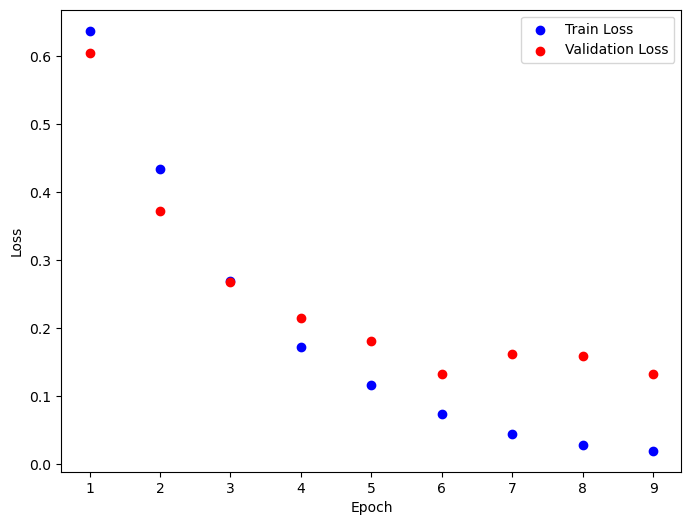

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(range(1, len(train_losses)+1), train_losses, label="Train Loss", color='blue', marker='o')
plt.scatter(range(1, len(val_losses)+1), val_losses, label="Validation Loss", color='red', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

### 9.2 Model evaluation:

In [27]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for feats, label in loader:  # use the original loader with all slides
        feats = feats[0].to(device)
        label = label.float().to(device)
        y_hat, _, _ = model(feats)

        all_labels.append(label.item())
        all_preds.append(y_hat.item())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Binarize predictions at threshold 0.5
all_preds_bin = (all_preds >= 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds_bin)
precision = precision_score(all_labels, all_preds_bin)
recall = recall_score(all_labels, all_preds_bin)
f1 = f1_score(all_labels, all_preds_bin)
auc = roc_auc_score(all_labels, all_preds)

print(f"Overall Metrics (all {len(all_labels)} slides):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


# only on the validation set:
bestmodel_val_probs = np.array(bestmodel_val_probs)
val_preds_bin = (bestmodel_val_probs >= 0.5).astype(int)

accuracy = accuracy_score(bestmodel_val_labels, val_preds_bin)
precision = precision_score(bestmodel_val_labels, val_preds_bin)
recall = recall_score(bestmodel_val_labels, val_preds_bin)
f1 = f1_score(bestmodel_val_labels, val_preds_bin)
auc = roc_auc_score(bestmodel_val_labels, val_preds_bin)

print(f"Overall Metrics (all {len(val_preds_bin)} slides), validation set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Overall Metrics (all 100 slides):
Accuracy: 0.9900
Precision: 0.9808
Recall: 1.0000
F1-score: 0.9903
AUC: 1.0000
Overall Metrics (all 20 slides), validation set:
Accuracy: 0.9500
Precision: 0.8750
Recall: 1.0000
F1-score: 0.9333
AUC: 0.9615


### 11. Test labels

In [28]:
test_embedding_folder = os.path.join(trident_folder,"trident_processed_hest_test/20x_256px_0px_overlap/features_uni_v2")
predictions = []

model.eval()
with torch.no_grad():
    for fname in os.listdir(test_embedding_folder):
        fpath = os.path.join(test_embedding_folder, fname)
        base_name = os.path.splitext(fname)[0]
        # load features
        with h5py.File(fpath, "r") as f:
            feats = f["features"][:]  # (N_patches, D)

        feats = torch.tensor(feats, dtype=torch.float32).to(device)
        # run model
        y_hat, _, _ = model(feats)     # probability
        prob = y_hat.item()
        pred_label = prob >= 0.5
        predictions.append({"slide_id": base_name, "pred": pred_label})

# Save predictions to CSV
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions.csv", index=False)
print(f"Saved {len(pred_df)} predictions to predictions.csv")

Saved 25 predictions to predictions.csv
